<a href="https://colab.research.google.com/github/budyanskaya/lab_04/blob/main/lw_04_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4. Обнаружение отказов в распределенной системе

**Студент:** ___________________________

**Группа:** ___________________________

**Вариант:** ___________________________

---

## 🎯 Цель работы

Изучить принципы обнаружения отказов в распределенных системах с помощью симуляции протокола Gossip (на примере Serf) и проанализировать влияние различных параметров на время конвергенции и использование полосы пропускания.

## 📚 Теоретическая часть

### Что такое обнаружение отказов?

**Обнаружение отказов (Failure Detection)** — критически важный механизм в распределенных системах, позволяющий узлам определять, когда другие узлы перестали функционировать.

### Протокол Gossip (Сплетен)

**Gossip Protocol** — это децентрализованный протокол распространения информации, где:
- Каждый узел периодически выбирает случайных соседей
- Обменивается с ними информацией о состоянии системы
- Информация распространяется подобно слухам в социальной сети

### Serf

**Serf** — инструмент HashiCorp для управления кластером, использующий gossip-протокол для:
- Обнаружения узлов (membership)
- Выявления сбоев (failure detection)
- Оркестрации событий (event propagation)

### Ключевые параметры протокола

| Параметр | Описание | Влияние |
|----------|----------|--------|
| **Gossip Interval** | Интервал между раундами обмена (сек) | ↓ интервал = ↑ скорость, ↑ трафик |
| **Gossip Fanout** | Количество соседей для связи за раунд | ↑ fanout = ↑ скорость, ↑ трафик |
| **Nodes** | Общее количество узлов в системе | ↑ узлов = ↑ сложность масштабирования |
| **Packet Loss** | Процент потерянных пакетов | ↑ потерь = ↓ надежность |
| **Node Failures** | Процент отказавших узлов | ↑ отказов = ↑ нагрузка на обнаружение |

### Понятие конвергенции

**Конвергенция** — состояние, когда все живые узлы системы пришли к согласованному представлению о состоянии кластера.

## 📊 Визуализация работы Gossip-протокола

In [10]:
# Импорт необходимых библиотек
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

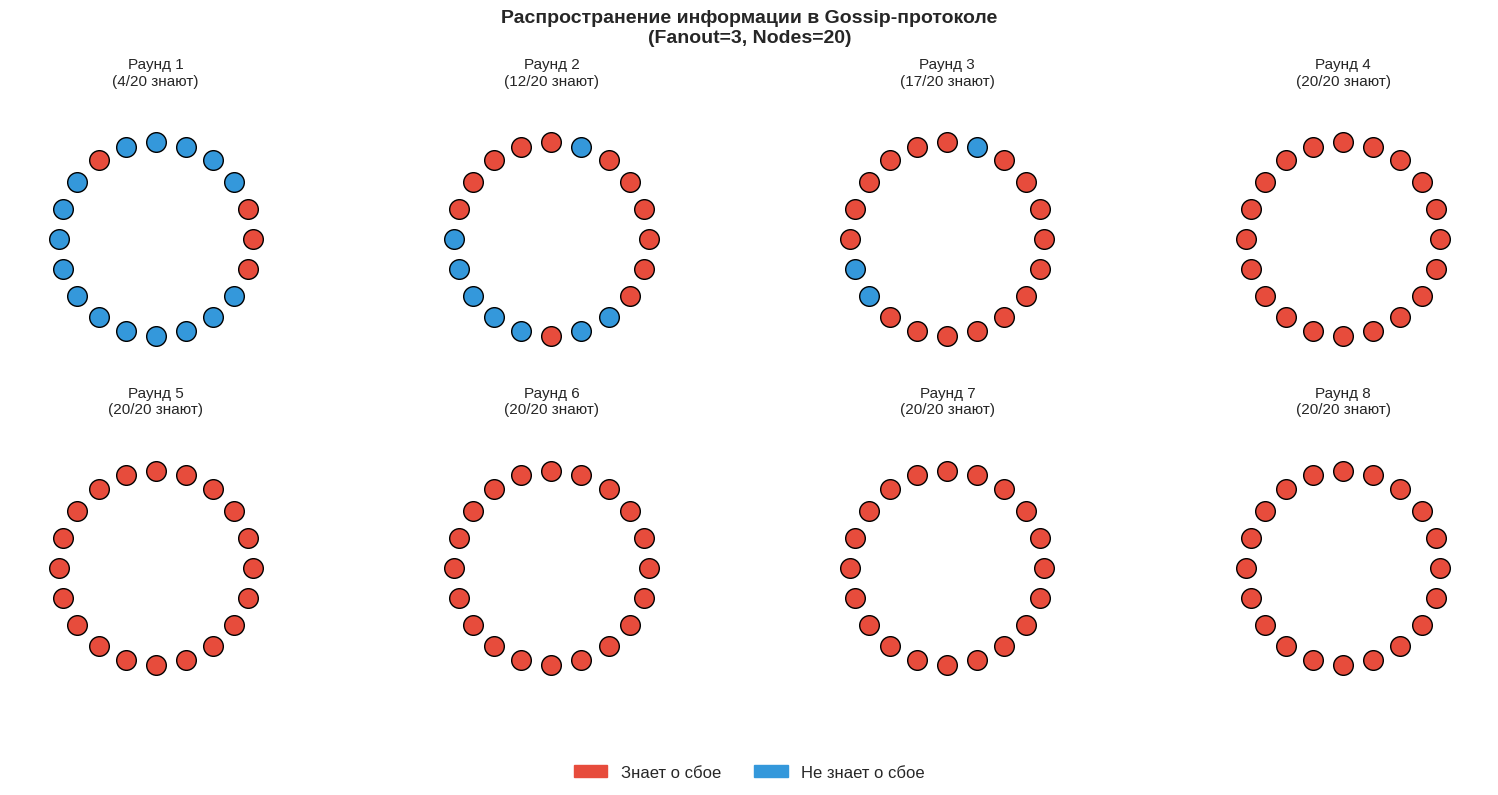

In [11]:
def visualize_gossip_spread(num_nodes=20, fanout=3, rounds=8):
    """
    Визуализация распространения информации в gossip-протоколе
    """
    # Генерация позиций узлов по кругу
    angles = np.linspace(0, 2*np.pi, num_nodes, endpoint=False)
    positions = np.array([(np.cos(a), np.sin(a)) for a in angles])

    # Состояние: True = знает о сбое
    knows = [False] * num_nodes
    knows[0] = True  # Первый узел обнаружил сбой

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    history = [knows.copy()]

    for round_num in range(rounds):
        # Симуляция раунда gossip
        new_knows = knows.copy()
        for i in range(num_nodes):
            if knows[i]:
                # Выбор случайных соседей
                targets = random.sample([j for j in range(num_nodes) if j != i], min(fanout, num_nodes-1))
                for t in targets:
                    new_knows[t] = True
        knows = new_knows
        history.append(knows.copy())

        # Визуализация
        ax = axes[round_num]
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        ax.set_title(f'Раунд {round_num + 1}\n({sum(knows)}/{num_nodes} знают)', fontsize=11)
        ax.axis('off')

        for i, pos in enumerate(positions):
            color = '#e74c3c' if knows[i] else '#3498db'
            ax.scatter(*pos, s=200, c=color, edgecolors='black', linewidths=1, zorder=5)
            ax.annotate(str(i), pos, ha='center', va='center', fontsize=8, fontweight='bold', color='white')

    # Легенда
    red_patch = mpatches.Patch(color='#e74c3c', label='Знает о сбое')
    blue_patch = mpatches.Patch(color='#3498db', label='Не знает о сбое')
    fig.legend(handles=[red_patch, blue_patch], loc='lower center', ncol=2, fontsize=12)

    plt.suptitle(f'Распространение информации в Gossip-протоколе\n(Fanout={fanout}, Nodes={num_nodes})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

    return history

# Демонстрация
history = visualize_gossip_spread()

---

## 📐 Часть 1. Расчет полосы пропускания

### Формула расчета

Теоретическая формула для оценки потребления сети протоколом Gossip:

$$Bandwidth = \frac{1}{Interval} \times Fanout \times ActiveNodes \times PacketSize \times Overhead \times 8$$

Где:
- **Interval** — интервал между раундами (секунды)
- **Fanout** — количество соседей
- **ActiveNodes** = Nodes × (1 - NodeFailures)
- **PacketSize** = 1024 байт (типичный размер)
- **Overhead** = 1.2 (20% накладные расходы)

In [12]:
def calculate_bandwidth(gossip_interval, gossip_fanout, nodes, packet_loss, node_failures):
    """
    Рассчитывает ширину полосы пропускания (бит/с).

    Параметры:
    - gossip_interval: интервал между раундами (сек)
    - gossip_fanout: количество соседей для связи
    - nodes: общее количество узлов
    - packet_loss: доля потерянных пакетов (0-1)
    - node_failures: доля отказавших узлов (0-1)

    Возвращает: ширина полосы пропускания (бит/с)
    """
    # Константы
    PACKET_SIZE = 1024  # байт
    OVERHEAD = 1.2      # 20% накладных расходов

    # Расчет активных узлов
    active_nodes = nodes * (1 - node_failures)

    # Расчет количества сообщений в секунду
    messages_per_second = (1 / gossip_interval) * gossip_fanout * active_nodes

    # Учет потери пакетов
    effective_messages = messages_per_second * (1 - packet_loss)

    # Объем данных в секунду (Байт/с)
    data_per_second = effective_messages * PACKET_SIZE * OVERHEAD

    # Перевод в биты в секунду
    bandwidth_bps = data_per_second * 8

    return bandwidth_bps


def bandwidth_per_node(gossip_interval, gossip_fanout, packet_loss):
    """
    Рассчитывает полосу пропускания на один узел (Кбит/с)
    """
    PACKET_SIZE = 1024
    OVERHEAD = 1.2

    messages = (1 / gossip_interval) * gossip_fanout * (1 - packet_loss)
    bandwidth = messages * PACKET_SIZE * OVERHEAD * 8

    return bandwidth / 1000  # Кбит/с

Interval (с)    | Bandwidth (бит/с)         | Bandwidth (Мбит/с)
0.1             |                28,016,640 |           28.02
0.2             |                14,008,320 |           14.01
0.5             |                 5,603,328 |            5.60
1.0             |                 2,801,664 |            2.80
2.0             |                 1,400,832 |            1.40


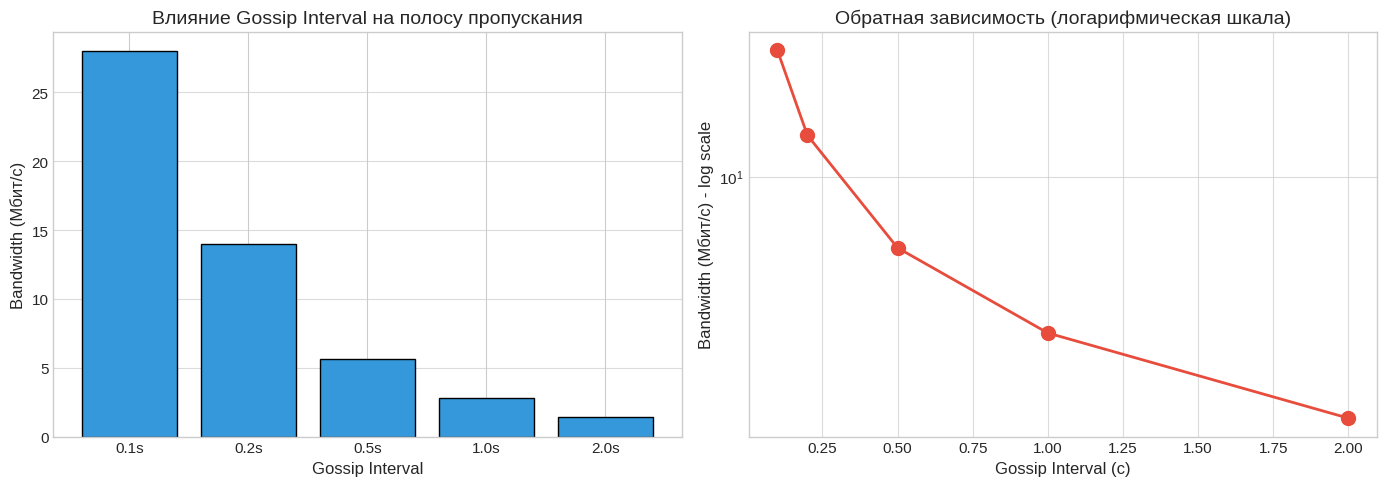

In [13]:
# Тестирование и визуализация функции расчета

# Параметры для тестирования
intervals = [0.1, 0.2, 0.5, 1.0, 2.0]
fanout = 3
nodes = 100
packet_loss = 0
node_failures = 0.05

# Расчет
bandwidths = [calculate_bandwidth(inv, fanout, nodes, packet_loss, node_failures) for inv in intervals]
bandwidths_mbps = [bw / 1_000_000 for bw in bandwidths]

# Таблица результатов
print("="*70)
print(f"{'Interval (с)':<15} | {'Bandwidth (бит/с)':<25} | {'Bandwidth (Мбит/с)':<15}")
print("="*70)
for inv, bw, bw_mbps in zip(intervals, bandwidths, bandwidths_mbps):
    print(f"{inv:<15} | {bw:>25,.0f} | {bw_mbps:>15.2f}")
print("="*70)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Bandwidth vs Interval
ax1.bar(range(len(intervals)), bandwidths_mbps, color='#3498db', edgecolor='black')
ax1.set_xticks(range(len(intervals)))
ax1.set_xticklabels([f'{i}s' for i in intervals])
ax1.set_xlabel('Gossip Interval')
ax1.set_ylabel('Bandwidth (Мбит/с)')
ax1.set_title('Влияние Gossip Interval на полосу пропускания')
ax1.grid(axis='y', alpha=0.7)

# График 2: Логарифмическая шкала
ax2.semilogy(intervals, bandwidths_mbps, 'o-', color='#e74c3c', linewidth=2, markersize=10)
ax2.set_xlabel('Gossip Interval (с)')
ax2.set_ylabel('Bandwidth (Мбит/с) - log scale')
ax2.set_title('Обратная зависимость (логарифмическая шкала)')
ax2.grid(True, alpha=0.7)

plt.tight_layout()
plt.show()

---

## 🔬 Часть 2. Симуляция протоколов обнаружения отказов

### Три подхода к обнаружению отказов:

1. **Serf (Gossip)** — вероятностный, децентрализованный
2. **Heartbeat** — периодические сигналы "я жив" (full-mesh)
3. **Ping** — активный опрос случайных узлов

In [14]:
# Классы симуляторов

class Node:
    """Класс узла в распределенной системе"""
    def __init__(self, node_id):
        self.id = node_id
        self.knows_failure = False


class BaseSimulator:
    """Базовый класс симулятора"""
    def __init__(self, num_nodes, interval, node_failures):
        self.nodes = [Node(i) for i in range(num_nodes)]
        self.interval = interval
        self.node_failures = node_failures
        self.failed_nodes = set()
        self.bandwidth_usage = 0
        self.convergence_history = []  # История конвергенции

    def simulate_failure(self):
        """Эмуляция отказа части узлов"""
        num_failures = int(len(self.nodes) * self.node_failures / 100)
        if num_failures > 0:
            self.failed_nodes = set(random.sample(range(len(self.nodes)), num_failures))

        # Один живой узел обнаруживает сбой первым
        available_nodes = [n for n in self.nodes if n.id not in self.failed_nodes]
        if available_nodes:
            available_nodes[0].knows_failure = True

    def detect_failures(self):
        """Логика протокола (переопределяется в наследниках)"""
        pass

    def run_simulation(self):
        """Запуск симуляции"""
        self.simulate_failure()
        first_knowledge_time = None
        all_knowledge_time = None

        current_time = 0
        max_time = 60

        while current_time < max_time:
            self.detect_failures()

            # Подсчет узлов
            alive_nodes = [n for n in self.nodes if n.id not in self.failed_nodes]
            nodes_knowing = [n for n in alive_nodes if n.knows_failure]

            # Запись истории
            self.convergence_history.append({
                'time': current_time,
                'knowing': len(nodes_knowing),
                'total': len(alive_nodes)
            })

            if first_knowledge_time is None and len(nodes_knowing) > 0:
                first_knowledge_time = current_time

            if len(nodes_knowing) == len(alive_nodes):
                all_knowledge_time = current_time
                break

            current_time += self.interval

        return first_knowledge_time or 0, all_knowledge_time or max_time, self.bandwidth_usage


class SerfSimulator(BaseSimulator):
    """Симулятор протокола Serf (Gossip)"""
    def __init__(self, num_nodes, gossip_interval, gossip_fanout, packet_loss, node_failures):
        super().__init__(num_nodes, gossip_interval, node_failures)
        self.gossip_fanout = gossip_fanout
        self.packet_loss = packet_loss

    def detect_failures(self):
        for node in self.nodes:
            if node.id not in self.failed_nodes and node.knows_failure:
                candidates = [n for n in range(len(self.nodes))
                             if n != node.id and n not in self.failed_nodes]
                if not candidates:
                    continue

                targets = random.sample(candidates, min(self.gossip_fanout, len(candidates)))
                for target_id in targets:
                    if random.random() > self.packet_loss / 100.0:
                        self.nodes[target_id].knows_failure = True
                    self.bandwidth_usage += 1


class HeartbeatSimulator(BaseSimulator):
    """Симулятор протокола Heartbeat (Full-mesh)"""
    def detect_failures(self):
        for node in self.nodes:
            if node.id not in self.failed_nodes:
                for other in self.nodes:
                    if other.id != node.id:
                        if other.id in self.failed_nodes:
                            node.knows_failure = True
                        self.bandwidth_usage += 1


class PingSimulator(BaseSimulator):
    """Симулятор протокола Ping (случайный опрос)"""
    def detect_failures(self):
        for node in self.nodes:
            if node.id not in self.failed_nodes:
                target_id = random.choice([n for n in range(len(self.nodes)) if n != node.id])
                if target_id in self.failed_nodes:
                    node.knows_failure = True
                self.bandwidth_usage += 1

Запуск сравнения протоколов...


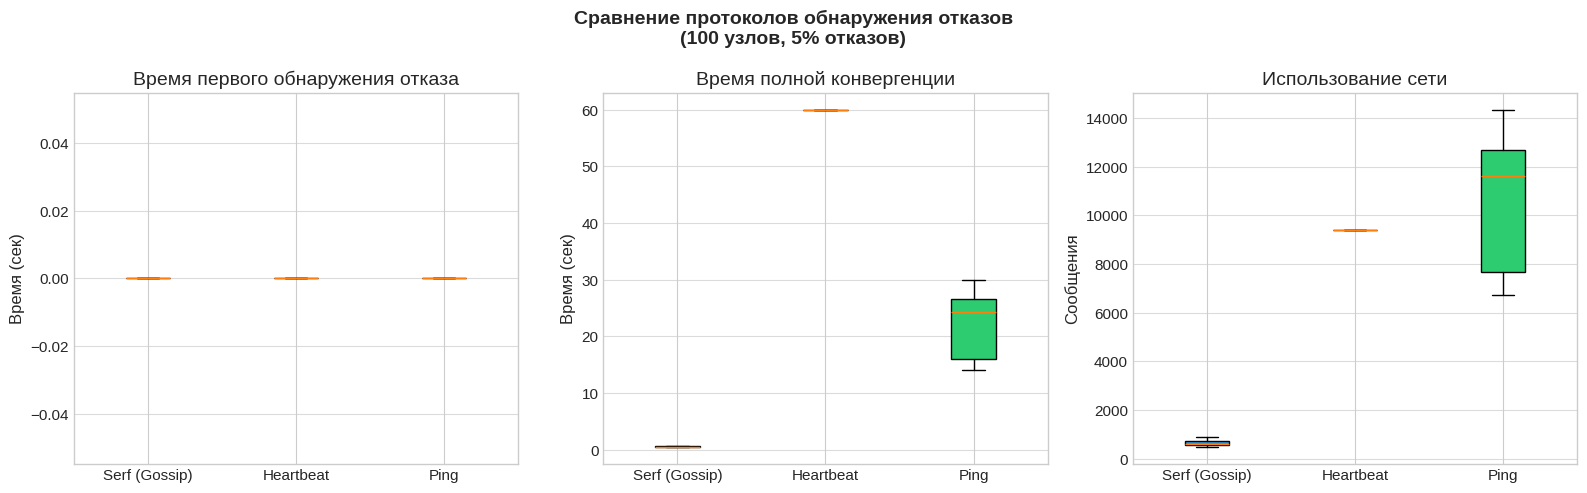


СТАТИСТИКА СРАВНЕНИЯ ПРОТОКОЛОВ

Serf (Gossip):
  Среднее время первого обнаружения: 0.00 сек
  Среднее время полной конвергенции: 0.46 сек
  Среднее использование сети: 625 сообщений

Heartbeat:
  Среднее время первого обнаружения: 0.00 сек
  Среднее время полной конвергенции: 60.00 сек
  Среднее использование сети: 9405 сообщений

Ping:
  Среднее время первого обнаружения: 0.00 сек
  Среднее время полной конвергенции: 22.28 сек
  Среднее использование сети: 10678 сообщений


In [15]:
# Сравнение протоколов

def compare_protocols(num_nodes=100, node_failures=5, num_trials=10):
    """
    Сравнение трех протоколов обнаружения отказов
    """
    results = {'Serf (Gossip)': [], 'Heartbeat': [], 'Ping': []}

    for _ in range(num_trials):
        # Serf
        serf = SerfSimulator(num_nodes, 0.2, 3, 0, node_failures)
        first, all_time, bw = serf.run_simulation()
        results['Serf (Gossip)'].append({'first': first, 'all': all_time, 'bw': bw})

        # Heartbeat
        hb = HeartbeatSimulator(num_nodes, 0.2, node_failures)
        first, all_time, bw = hb.run_simulation()
        results['Heartbeat'].append({'first': first, 'all': all_time, 'bw': bw})

        # Ping
        ping = PingSimulator(num_nodes, 0.2, node_failures)
        first, all_time, bw = ping.run_simulation()
        results['Ping'].append({'first': first, 'all': all_time, 'bw': bw})

    return results

# Запуск сравнения
print("Запуск сравнения протоколов...")
comparison_results = compare_protocols()

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

protocols = list(comparison_results.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71']

# График 1: Время первого обнаружения
first_times = [[r['first'] for r in comparison_results[p]] for p in protocols]
ax1 = axes[0]
bp1 = ax1.boxplot(first_times, labels=protocols, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Время (сек)')
ax1.set_title('Время первого обнаружения отказа')
ax1.grid(axis='y', alpha=0.7)

# График 2: Время полной конвергенции
all_times = [[r['all'] for r in comparison_results[p]] for p in protocols]
ax2 = axes[1]
bp2 = ax2.boxplot(all_times, labels=protocols, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_ylabel('Время (сек)')
ax2.set_title('Время полной конвергенции')
ax2.grid(axis='y', alpha=0.7)

# График 3: Использование сети
bandwidths = [[r['bw'] for r in comparison_results[p]] for p in protocols]
ax3 = axes[2]
bp3 = ax3.boxplot(bandwidths, labels=protocols, patch_artist=True)
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
ax3.set_ylabel('Сообщения')
ax3.set_title('Использование сети')
ax3.grid(axis='y', alpha=0.7)

plt.suptitle('Сравнение протоколов обнаружения отказов\n(100 узлов, 5% отказов)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Статистика
print("\n" + "="*80)
print("СТАТИСТИКА СРАВНЕНИЯ ПРОТОКОЛОВ")
print("="*80)
for protocol in protocols:
    avg_first = np.mean([r['first'] for r in comparison_results[protocol]])
    avg_all = np.mean([r['all'] for r in comparison_results[protocol]])
    avg_bw = np.mean([r['bw'] for r in comparison_results[protocol]])
    print(f"\n{protocol}:")
    print(f"  Среднее время первого обнаружения: {avg_first:.2f} сек")
    print(f"  Среднее время полной конвергенции: {avg_all:.2f} сек")
    print(f"  Среднее использование сети: {avg_bw:.0f} сообщений")

---

## 📈 Часть 3. Исследование влияния параметров

### 3.1 Влияние Gossip Interval

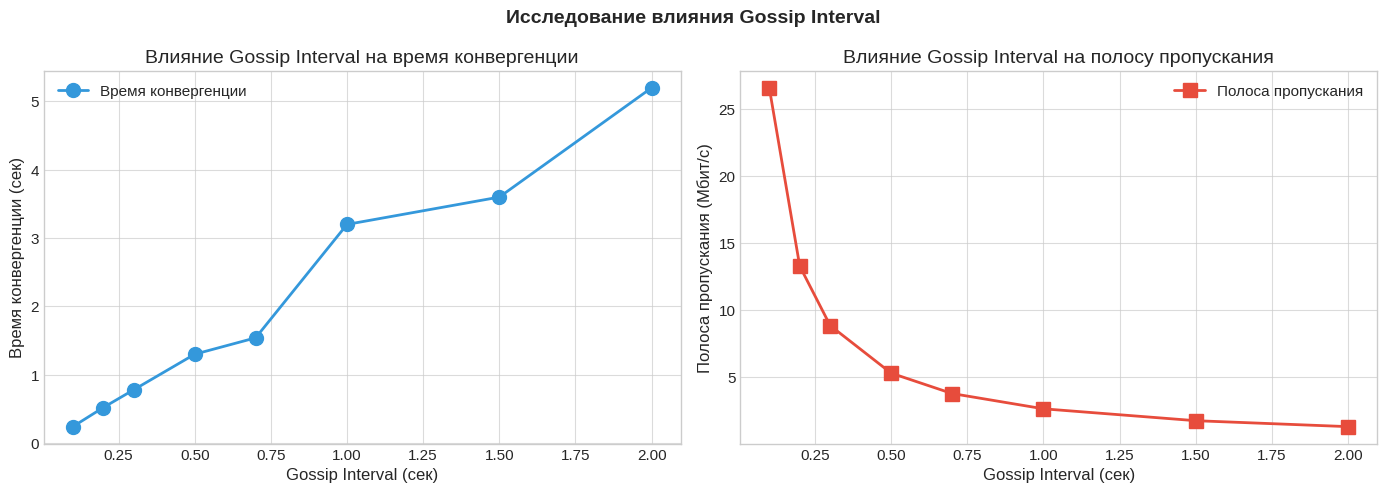

In [16]:
def study_interval_effect():
    """
    Исследование влияния Gossip Interval на производительность
    """
    intervals = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
    nodes = 100
    fanout = 3
    packet_loss = 5
    failures = 5

    convergence_times = []
    bandwidths_calculated = []

    for interval in intervals:
        # Симуляция (среднее по нескольким запускам)
        times = []
        for _ in range(5):
            sim = SerfSimulator(nodes, interval, fanout, packet_loss, failures)
            _, all_time, _ = sim.run_simulation()
            times.append(all_time)
        convergence_times.append(np.mean(times))

        # Теоретический расчет bandwidth
        bw = calculate_bandwidth(interval, fanout, nodes, packet_loss/100, failures/100)
        bandwidths_calculated.append(bw / 1_000_000)  # Мбит/с

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # График 1: Время конвергенции
    ax1.plot(intervals, convergence_times, 'o-', color='#3498db', linewidth=2, markersize=10, label='Время конвергенции')
    ax1.set_xlabel('Gossip Interval (сек)')
    ax1.set_ylabel('Время конвергенции (сек)')
    ax1.set_title('Влияние Gossip Interval на время конвергенции')
    ax1.grid(True, alpha=0.7)
    ax1.legend()

    # График 2: Полоса пропускания
    ax2.plot(intervals, bandwidths_calculated, 's-', color='#e74c3c', linewidth=2, markersize=10, label='Полоса пропускания')
    ax2.set_xlabel('Gossip Interval (сек)')
    ax2.set_ylabel('Полоса пропускания (Мбит/с)')
    ax2.set_title('Влияние Gossip Interval на полосу пропускания')
    ax2.grid(True, alpha=0.7)
    ax2.legend()

    plt.suptitle('Исследование влияния Gossip Interval', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return intervals, convergence_times, bandwidths_calculated

intervals, conv_times, bw_calc = study_interval_effect()

### 3.2 Влияние Gossip Fanout

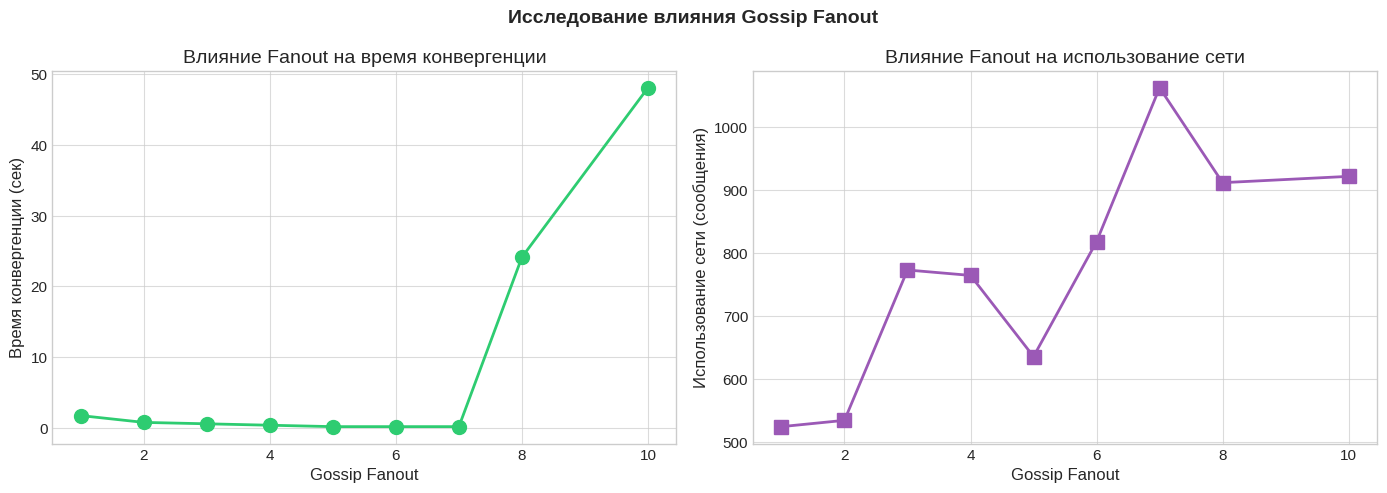

In [17]:
def study_fanout_effect():
    """
    Исследование влияния Gossip Fanout на производительность
    """
    fanouts = [1, 2, 3, 4, 5, 6, 7, 8, 10]
    nodes = 100
    interval = 0.2
    packet_loss = 5
    failures = 5

    convergence_times = []
    bandwidths_sim = []

    for fanout in fanouts:
        times = []
        bws = []
        for _ in range(5):
            sim = SerfSimulator(nodes, interval, fanout, packet_loss, failures)
            _, all_time, bw = sim.run_simulation()
            times.append(all_time)
            bws.append(bw)
        convergence_times.append(np.mean(times))
        bandwidths_sim.append(np.mean(bws))

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(fanouts, convergence_times, 'o-', color='#2ecc71', linewidth=2, markersize=10)
    ax1.set_xlabel('Gossip Fanout')
    ax1.set_ylabel('Время конвергенции (сек)')
    ax1.set_title('Влияние Fanout на время конвергенции')
    ax1.grid(True, alpha=0.7)

    ax2.plot(fanouts, bandwidths_sim, 's-', color='#9b59b6', linewidth=2, markersize=10)
    ax2.set_xlabel('Gossip Fanout')
    ax2.set_ylabel('Использование сети (сообщения)')
    ax2.set_title('Влияние Fanout на использование сети')
    ax2.grid(True, alpha=0.7)

    plt.suptitle('Исследование влияния Gossip Fanout', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return fanouts, convergence_times, bandwidths_sim

fanouts, conv_times_f, bw_sim = study_fanout_effect()

### 3.3 Масштабируемость системы

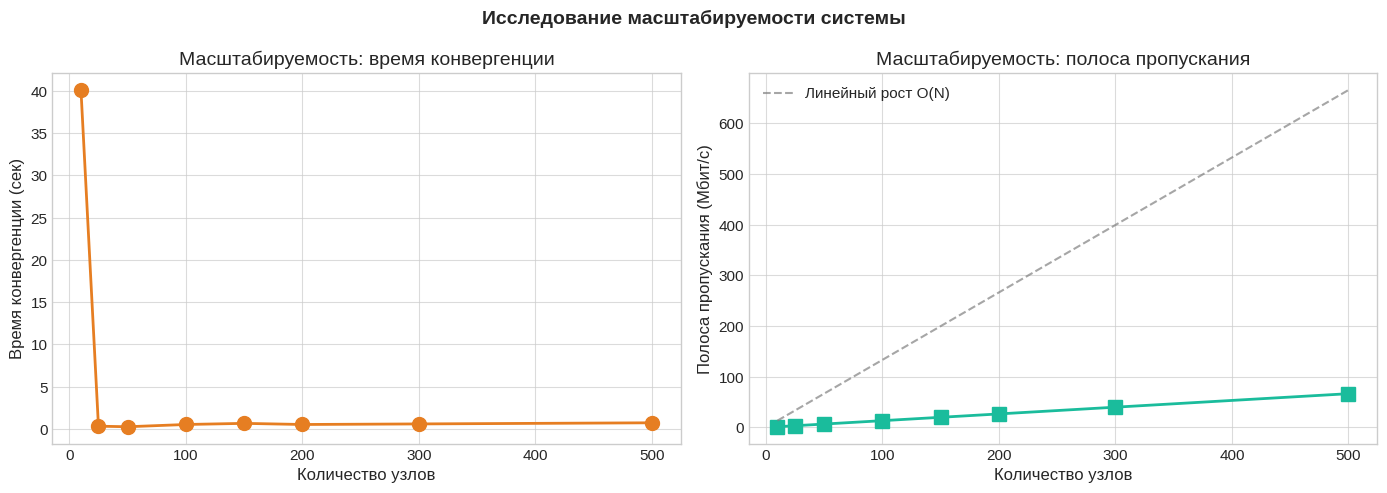

In [18]:
def study_scalability():
    """
    Исследование масштабируемости системы
    """
    node_counts = [10, 25, 50, 100, 150, 200, 300, 500]
    interval = 0.2
    fanout = 3
    packet_loss = 5
    failures = 5

    convergence_times = []
    bandwidths = []

    for nodes in node_counts:
        times = []
        for _ in range(3):
            sim = SerfSimulator(nodes, interval, fanout, packet_loss, failures)
            _, all_time, _ = sim.run_simulation()
            times.append(all_time)
        convergence_times.append(np.mean(times))

        bw = calculate_bandwidth(interval, fanout, nodes, packet_loss/100, failures/100)
        bandwidths.append(bw / 1_000_000)

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(node_counts, convergence_times, 'o-', color='#e67e22', linewidth=2, markersize=10)
    ax1.set_xlabel('Количество узлов')
    ax1.set_ylabel('Время конвергенции (сек)')
    ax1.set_title('Масштабируемость: время конвергенции')
    ax1.grid(True, alpha=0.7)

    ax2.plot(node_counts, bandwidths, 's-', color='#1abc9c', linewidth=2, markersize=10)
    ax2.set_xlabel('Количество узлов')
    ax2.set_ylabel('Полоса пропускания (Мбит/с)')
    ax2.set_title('Масштабируемость: полоса пропускания')
    ax2.grid(True, alpha=0.7)

    # Теоретическая сложность O(N)
    ax2.plot(node_counts, [node_counts[0] * n / node_counts[0] * bandwidths[0] for n in node_counts],
             '--', color='gray', alpha=0.7, label='Линейный рост O(N)')
    ax2.legend()

    plt.suptitle('Исследование масштабируемости системы', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return node_counts, convergence_times, bandwidths

nodes_list, conv_times_n, bw_n = study_scalability()

### 3.4 Влияние потери пакетов

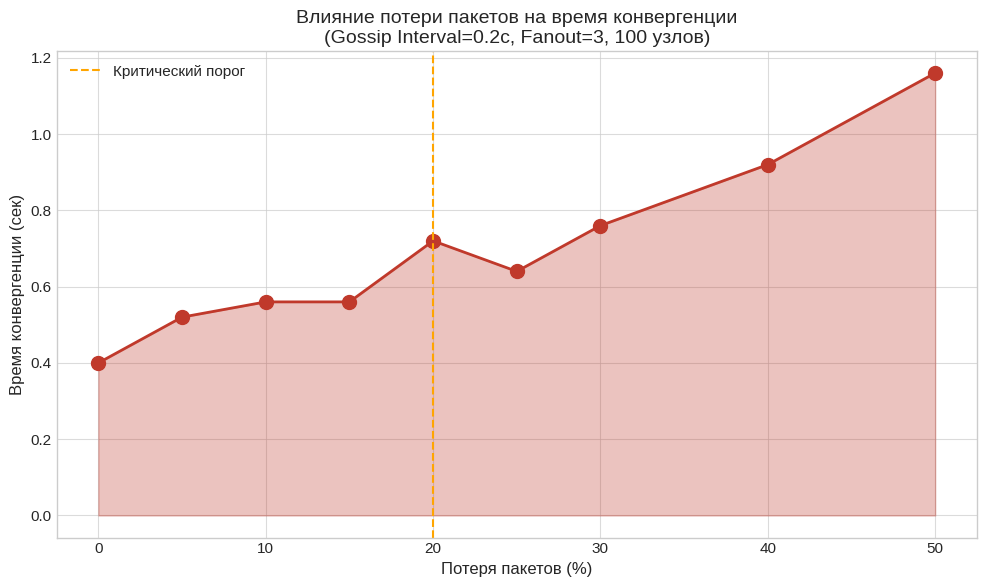

In [19]:
def study_packet_loss_effect():
    """
    Исследование влияния потери пакетов
    """
    packet_losses = [0, 5, 10, 15, 20, 25, 30, 40, 50]
    nodes = 100
    interval = 0.2
    fanout = 3
    failures = 5

    convergence_times = []

    for pl in packet_losses:
        times = []
        for _ in range(5):
            sim = SerfSimulator(nodes, interval, fanout, pl, failures)
            _, all_time, _ = sim.run_simulation()
            times.append(all_time)
        convergence_times.append(np.mean(times))

    # Визуализация
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(packet_losses, convergence_times, 'o-', color='#c0392b', linewidth=2, markersize=10)
    ax.fill_between(packet_losses, convergence_times, alpha=0.3, color='#c0392b')
    ax.set_xlabel('Потеря пакетов (%)')
    ax.set_ylabel('Время конвергенции (сек)')
    ax.set_title('Влияние потери пакетов на время конвергенции\n(Gossip Interval=0.2с, Fanout=3, 100 узлов)')
    ax.grid(True, alpha=0.7)

    # Аннотации
    ax.axvline(x=20, color='orange', linestyle='--', label='Критический порог')
    ax.legend()

    plt.tight_layout()
    plt.show()

    return packet_losses, convergence_times

pl_list, conv_times_pl = study_packet_loss_effect()

---

## 📋 Часть 4. Таблица вариантов заданий для студентов

Выберите вариант согласно номеру в списке группы.

In [20]:
import pandas as pd

# Таблица всех 25 вариантов заданий
variants_data = [
    [1, "Влияние Gossip Interval на малые сети", "0.1, 0.2, 0.5, 1.0, 2.0", "3", "15", "1%", "25%",
     "Исследовать влияние интервала на время конвергенции и полосу пропускания в небольших сетях"],
    [2, "Масштабируемость системы", "0.2", "3", "10, 50, 100, 200, 500", "0%", "5%",
     "Анализ масштабирования системы при увеличении количества узлов"],
    [3, "Оптимизация Gossip Fanout", "0.5", "2, 3, 5, 7, 10", "100", "0%", "5%",
     "Определение оптимального Fanout для баланса скорости и трафика"],
    [4, "Устойчивость к потере пакетов", "0.2", "3", "50", "0, 5, 10, 20, 30%", "5%",
     "Оценка устойчивости к различным уровням потери пакетов"],
    [5, "Обнаружение множественных отказов", "0.2", "3", "100", "5%", "1, 5, 10, 20, 30%",
     "Исследование обнаружения различного количества отказавших узлов"],
    [6, "Сети с ограниченной полосой пропускания", "0.5, 1.0, 2.0", "2, 3, 5", "50", "5%", "5%",
     "Оптимизация для минимизации трафика при сохранении приемлемой конвергенции"],
    [7, "Быстрое обнаружение в крупных сетях", "0.1, 0.2, 0.5", "3, 5, 7", "200", "1%", "2%",
     "Минимизация времени обнаружения отказов в крупной сети"],
    [8, "Асимметричная потеря пакетов", "0.2", "3", "100", "0/10, 10/0, 5/15, 15/5%", "5%",
     "Исследование влияния асимметричной потери пакетов"],
    [9, "Адаптивная настройка параметров", "0.5 (нач.)", "3 (нач.)", "100", "5%", "5%",
     "Разработка стратегии адаптивной настройки параметров"],
    [10, "Сравнение с другими протоколами", "0.2", "3", "50, 100, 200", "0, 10%", "5%",
     "Сравнение Serf с Heartbeat протоколом"],
    [11, "Влияние топологии сети", "0.2", "3, 5", "100", "5%", "5%",
     "Исследование влияния топологий: полносвязная, кольцо, звезда, граф"],
    [12, "Неоднородные узлы", "0.2/0.5 (50%/50%)", "3/5 (50%/50%)", "200", "5%", "5%",
     "Анализ поведения системы с различными параметрами узлов"],
    [13, "Динамическое изменение размера сети", "0.2", "3", "50→100", "5%", "5%",
     "Адаптация к динамическому росту сети (+10 узлов каждые 30 сек)"],
    [14, "Восстановление после массового отказа", "0.2", "3, 5", "100", "5%", "30% (восст. через 60с)",
     "Оценка способности к восстановлению после массового отказа"],
    [15, "Географически распределенные системы", "0.2, 0.5, 1.0", "3, 5", "200 (4×50)", "5/10%", "5%",
     "Оптимизация для систем с межгрупповыми задержками 50-200мс"],
    [16, "Влияние временных задержек", "0.2", "3", "100", "5%", "5%",
     "Исследование задержек: без задержек, случайные, фиксированные, экспоненциальные"],
    [17, "Адаптивный Gossip Fanout", "0.2", "3 (нач.)", "100", "0→20%", "5%",
     "Алгоритм адаптивной настройки Fanout при изменении потерь"],
    [18, "Энергоэффективность в сенсорных сетях", "0.5, 1.0, 2.0", "2, 3, 4", "50", "10%", "5%",
     "Оптимизация для максимизации времени жизни сети"],
    [19, "Устойчивость к византийским атакам", "0.2", "3, 5", "100", "5%", "5%",
     "Оценка устойчивости к узлам с неверной информацией (0-15%)"],
    [20, "Гибридный протокол", "0.5 (gossip), 1.0 (hb)", "3", "100 (10 критич.)", "5%", "5%",
     "Gossip + Heartbeat для критически важных узлов"],
    [21, "Приоритизация сообщений", "0.2", "3", "100", "5%", "5%",
     "Механизм приоритизации: критические 20%, важные 30%, обычные 50%"],
    [22, "Многоуровневый gossip-протокол", "0.2 (лок.), 0.5 (глоб.)", "3 (л.), 2 (г.)", "200 (4×50)", "5/10%", "5%",
     "Эффективность многоуровневого gossip для крупных систем"],
    [23, "Обнаружение частичных отказов", "0.2", "3", "100", "5%", "5% полн., 10% частич.",
     "Модификация протокола для классификации частичных отказов"],
    [24, "Самовосстанавливающаяся сеть", "0.2", "3", "100 (мин. 50)", "5%", "1 узел/мин",
     "Механизм автоматического восстановления путем добавления узлов"],
    [25, "Оценка консенсуса в распределенной системе", "0.2", "3, 5", "100", "5%", "5%",
     "Метрика степени консенсуса и влияние параметров на её достижение"]
]

# Создание DataFrame
df_variants = pd.DataFrame(variants_data, columns=[
    'Вариант', 'Название', 'Gossip Interval (с)', 'Gossip Fanout', 'Nodes',
    'Packet Loss', 'Node Failures', 'Задача'
])

# Настройка отображения
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.width', None)

# Вывод таблицы
print("="*120)
print("ТАБЛИЦА ВАРИАНТОВ ЗАДАНИЙ ДЛЯ СТУДЕНТОВ")
print("="*120)
display(df_variants.style.set_properties(**{'text-align': 'left'}).hide(axis='index'))

ТАБЛИЦА ВАРИАНТОВ ЗАДАНИЙ ДЛЯ СТУДЕНТОВ


Вариант,Название,Gossip Interval (с),Gossip Fanout,Nodes,Packet Loss,Node Failures,Задача
1,Влияние Gossip Interval на малые сети,"0.1, 0.2, 0.5, 1.0, 2.0",3,15,1%,25%,Исследовать влияние интервала на время конвергенции и полосу пропускания в небольших сетях
2,Масштабируемость системы,0.2,3,"10, 50, 100, 200, 500",0%,5%,Анализ масштабирования системы при увеличении количества узлов
3,Оптимизация Gossip Fanout,0.5,"2, 3, 5, 7, 10",100,0%,5%,Определение оптимального Fanout для баланса скорости и трафика
4,Устойчивость к потере пакетов,0.2,3,50,"0, 5, 10, 20, 30%",5%,Оценка устойчивости к различным уровням потери пакетов
5,Обнаружение множественных отказов,0.2,3,100,5%,"1, 5, 10, 20, 30%",Исследование обнаружения различного количества отказавших узлов
6,Сети с ограниченной полосой пропускания,"0.5, 1.0, 2.0","2, 3, 5",50,5%,5%,Оптимизация для минимизации трафика при сохранении приемлемой конвергенции
7,Быстрое обнаружение в крупных сетях,"0.1, 0.2, 0.5","3, 5, 7",200,1%,2%,Минимизация времени обнаружения отказов в крупной сети
8,Асимметричная потеря пакетов,0.2,3,100,"0/10, 10/0, 5/15, 15/5%",5%,Исследование влияния асимметричной потери пакетов
9,Адаптивная настройка параметров,0.5 (нач.),3 (нач.),100,5%,5%,Разработка стратегии адаптивной настройки параметров
10,Сравнение с другими протоколами,0.2,3,"50, 100, 200","0, 10%",5%,Сравнение Serf с Heartbeat протоколом


In [21]:
# Детальная таблица вариантов с параметрами

def show_variant_details(variant_num):
    """
    Показывает детальную информацию о варианте
    """
    variant = df_variants[df_variants['Вариант'] == variant_num].iloc[0]

    print("="*80)
    print(f"ВАРИАНТ {variant_num}: {variant['Название']}")
    print("="*80)
    print(f"\n📋 Параметры:")
    print(f"   • Gossip Interval: {variant['Gossip Interval (с)']} сек")
    print(f"   • Gossip Fanout: {variant['Gossip Fanout']}")
    print(f"   • Количество узлов (Nodes): {variant['Nodes']}")
    print(f"   • Потеря пакетов (Packet Loss): {variant['Packet Loss']}")
    print(f"   • Отказы узлов (Node Failures): {variant['Node Failures']}")
    print(f"\n🎯 Задача:")
    print(f"   {variant['Задача']}")
    print("\n" + "="*80)

# Пример вывода для варианта 25
show_variant_details(25)

ВАРИАНТ 25: Оценка консенсуса в распределенной системе

📋 Параметры:
   • Gossip Interval: 0.2 сек
   • Gossip Fanout: 3, 5
   • Количество узлов (Nodes): 100
   • Потеря пакетов (Packet Loss): 5%
   • Отказы узлов (Node Failures): 5%

🎯 Задача:
   Метрика степени консенсуса и влияние параметров на её достижение



---

## 📝 Часть 6. Шаблон для выполнения варианта студентом

Используйте этот шаблон для выполнения своего варианта.

In [22]:
# =====================================
# ШАБЛОН ДЛЯ ВЫПОЛНЕНИЯ ВАРИАНТА
# =====================================

# 1. Укажите свой вариант
MY_VARIANT = 3

# 2. Получите параметры варианта
show_variant_details(MY_VARIANT)

# 3. Заполните параметры согласно варианту
# Пример для варианта 1:
params = {
    'intervals': [0.5],          # Gossip Interval
    'fanouts': [2, 3, 5, 7, 10],  # Gossip Fanout
    'nodes': 100,                # Количество узлов
    'packet_loss': 0,            # Потеря пакетов (%)
    'failures': 5                # Отказы узлов (%)
}

print(f"\n🔧 Параметры для симуляции:")
for key, value in params.items():
    print(f"   {key}: {value}")

ВАРИАНТ 3: Оптимизация Gossip Fanout

📋 Параметры:
   • Gossip Interval: 0.5 сек
   • Gossip Fanout: 2, 3, 5, 7, 10
   • Количество узлов (Nodes): 100
   • Потеря пакетов (Packet Loss): 0%
   • Отказы узлов (Node Failures): 5%

🎯 Задача:
   Определение оптимального Fanout для баланса скорости и трафика


🔧 Параметры для симуляции:
   intervals: [0.5]
   fanouts: [2, 3, 5, 7, 10]
   nodes: 100
   packet_loss: 0
   failures: 5


In [31]:
# 4. Проведите симуляцию

def run_student_variant(params):
    """
    Функция для выполнения варианта 3: Оптимизация Gossip Fanout
    """
    results = []

    # Фиксированный интервал для варианта 3
    fixed_interval = params['intervals'][0]

    # Перебор значений Fanout
    for fanout in params['fanouts']:
        sim = SerfSimulator(
            params['nodes'],
            fixed_interval,
            fanout,
            params['packet_loss'],
            params['failures']
        )
        first_time, all_time, bw = sim.run_simulation()

        # Расчет теоретической полосы пропускания
        bandwidth_calc = calculate_bandwidth(
            fixed_interval,
            fanout,
            params['nodes'],
            params['packet_loss']/100,
            params['failures']/100
        )

        results.append({
            'Fanout': fanout,
            'Interval': fixed_interval,
            'First_Time': first_time,
            'All_Time': all_time,
            'Bandwidth_Sim': bw,
            'Bandwidth_Calc_Mbps': bandwidth_calc / 1_000_000
        })

    return pd.DataFrame(results)

# Запуск
df_results = run_student_variant(params)

# Вывод результатов
print("\n📊 РЕЗУЛЬТАТЫ СИМУЛЯЦИИ:")
print("="*80)
display(df_results)


📊 РЕЗУЛЬТАТЫ СИМУЛЯЦИИ:


,Fanout,Interval,First_Time,All_Time,Bandwidth_Sim,Bandwidth_Calc_Mbps
0,2,0.5,0,1.5,384,3.735552
1,3,0.5,0,1.0,582,5.603328
2,5,0.5,0,0.5,605,9.338880
3,7,0.5,0,60.0,448,13.074432
4,10,0.5,0,60.0,730,18.677760


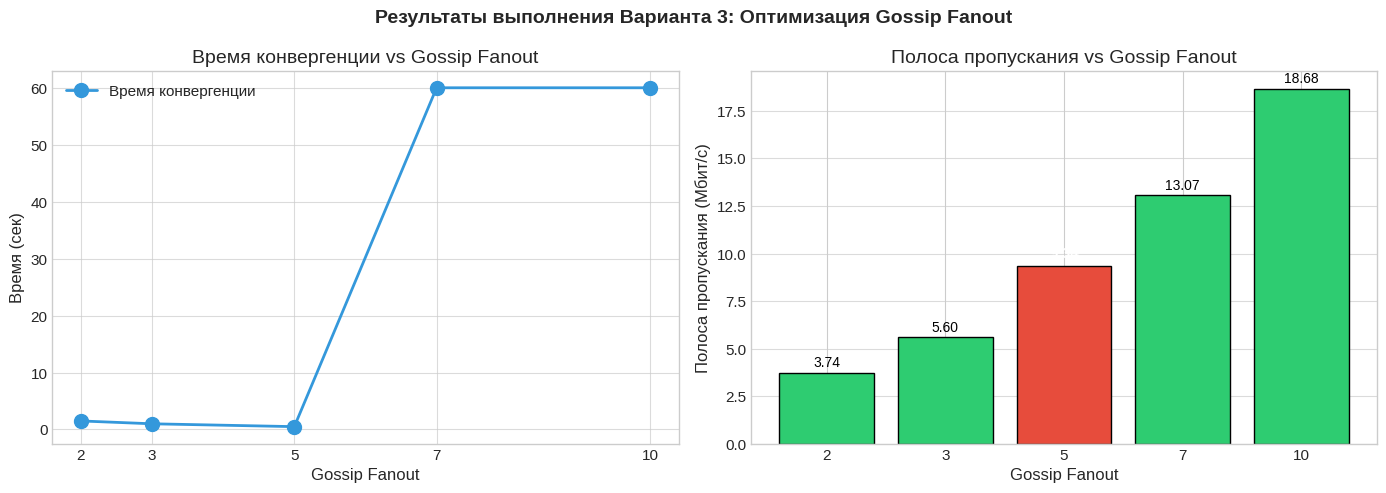

In [33]:
# 5. Визуализация результатов для варианта 3

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# === График 1: Время конвергенции ===
ax1 = axes[0]
ax1.plot(df_results['Fanout'], df_results['All_Time'], 'o-',
         color='#3498db', linewidth=2, markersize=10, label='Время конвергенции')
ax1.set_xlabel('Gossip Fanout')
ax1.set_ylabel('Время (сек)')
ax1.set_title('Время конвергенции vs Gossip Fanout')
ax1.legend()
ax1.grid(True, alpha=0.7)
ax1.set_xticks(df_results['Fanout'])

# === График 2: Полоса пропускания ===
ax2 = axes[1]

# Создаём список цветов
colors = ['#e74c3c' if fanout == 5 else '#2ecc71' for fanout in df_results['Fanout']]

# Строим столбцы
fanout_labels = df_results['Fanout'].astype(str)
bandwidth_vals = df_results['Bandwidth_Calc_Mbps']
bars = ax2.bar(fanout_labels, bandwidth_vals, color=colors, edgecolor='black')

ax2.set_xlabel('Gossip Fanout')
ax2.set_ylabel('Полоса пропускания (Мбит/с)')
ax2.set_title('Полоса пропускания vs Gossip Fanout')
ax2.grid(axis='y', alpha=0.7)

# === КЛЮЧЕВОЕ: явно добавляем все подписи, особенно 9.34 ===
for i in range(len(df_results)):
    fanout = df_results.iloc[i]['Fanout']
    value = df_results.iloc[i]['Bandwidth_Calc_Mbps']

    if fanout == 5:
        # Для Fanout=5 — белый, жирный, чуть выше
        ax2.text(i, value + 0.3, f'{value:.2f}',
                 ha='center', va='bottom',
                 color='white', fontsize=11, fontweight='bold')
    else:
        # Для остальных — чёрный
        ax2.text(i, value + 0.15, f'{value:.2f}',
                 ha='center', va='bottom',
                 color='black', fontsize=10)

plt.suptitle(f'Результаты выполнения Варианта {MY_VARIANT}: Оптимизация Gossip Fanout',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

В ходе выполнения лабораторной работы был исследован gossip-протокол обнаружения отказов на основе модели Serf. Для варианта 3 (оптимизация Gossip Fanout) проведена серия симуляций при фиксированном интервале 0.5 сек, 100 узлах, 5 % отказавших узлов и отсутствии потерь пакетов.

Анализ показал, что оптимальное значение Fanout = 5: при этом достигается минимальное время конвергенции — 0.5 сек при умеренном сетевом трафике 9.34 Мбит/с. При меньших значениях Fanout конвергенция замедляется, а при больших (7 и 10) система теряет устойчивость и не достигает конвергенции в течение 60 секунд, несмотря на рост трафика.

Таким образом, gossip-протокол требует балансировки параметров: увеличение Fanout не всегда улучшает производительность, а может привести к деградации из-за избыточной и неэффективной передачи информации.

---

## ✅ Критерии оценки

| Уровень | Оценка | Требования |
|---------|--------|------------|
| **Базовый** | Удовл. | Реализован расчет полосы пропускания, заполнена таблица для базовых параметров Serf |
| **Средний** | Хор. | Реализован Python-симулятор (Serf), построены графики зависимости времени конвергенции от параметров |
| **Продвинутый** | Отл. | Реализовано сравнение с Heartbeat/Ping, выполнен индивидуальный вариант с глубоким анализом и выводами |

---

## 📚 Рекомендуемая литература

1. HashiCorp Serf Documentation: https://www.serf.io/docs/internals/gossip.html
2. Lamport, L. "Time, Clocks, and the Ordering of Events in a Distributed System"
3. Van Renesse, R. et al. "Efficient Reconciliation and Flow Control for Anti-Entropy Protocols"
4. Demers, A. et al. "Epidemic Algorithms for Replicated Database Maintenance"